# Pinecone

클라우드 기반으로 동작

Pinecone은 고성능 벡터 데이터베이스로, AI 및 머신러닝 애플리케이션을 위한 효율적인 벡터 저장 및 검색 솔루션입니다. 

Pinecone, Chroma, Faiss와 같은 벡터 데이터베이스들을 비교해보겠습니다. 

**Pinecone의 장점**

1. 확장성: 대규모 데이터셋에 대해 뛰어난 확장성을 제공합니다.
   
2. 관리 용이성: 완전 관리형 서비스로, 인프라 관리 부담이 적습니다.
   
3. 실시간 업데이트: 데이터의 실시간 삽입, 업데이트, 삭제가 가능합니다.
   
4. 고가용성: 클라우드 기반으로 높은 가용성과 내구성을 제공합니다.
   
5. API 친화적: RESTful/Python API를 통해 쉽게 통합할 수 있습니다.

6. 무료 index 제공 (~5개 까지)
    - Read/Write 일정 시점 이상이면 비용 발생

**Pinecone의 단점**

1. 비용: Chroma나 Faiss에 비해 상대적으로 비용이 높을 수 있습니다.
   
2. 커스터마이징 제한: 완전 관리형 서비스이기 때문에 세부적인 커스터마이징에 제한이 있을 수 있습니다.
    - Chroma / Faiss는 Open Source
   
3. 데이터 위치: 클라우드에 데이터를 저장해야 하므로, 데이터 주권 문제가 있을 수 있습니다.
    - 무조건 클라우드 적재

Chroma나 Faiss와 비교했을 때:

- Chroma/FAISS 오픈소스이며 로컬에서 실행 가능하여 초기 비용이 낮고 데이터 제어가 용이합니다. 
- Chroma/FAISS 는 커스터마이징의 자유도가 높습니다. 
- Chroma/FAISS 는 대규모 확장성 면에서는 Pinecone에 비해 제한적일 수 있습니다.

선택은 프로젝트의 규모, 요구사항, 예산 등을 고려하여 결정해야 합니다. 

대규모 프로덕션 환경에서는 Pinecone이 유리할 수 있지만, 소규모 프로젝트나 실험적인 환경에서는 Chroma나 Faiss가 더 적합할 수 있습니다.

**참고**

- [Pinecone 공식 홈페이지](https://docs.pinecone.io/integrations/langchain)
- [Pinecone 랭체인](https://python.langchain.com/v0.2/docs/integrations/vectorstores/pinecone/)

In [3]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH09-VectorStores")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH09-VectorStores


## 업데이트 안내

아래의 기능은 커스텀 구현한 내용이므로 아래의 라이브러리를 반드시 업데이트 후 진행해야 합니다.

In [7]:
# 업데이트 명령어
# !pip install -U langchain-teddynote

## 한글 처리를 위한 불용어 사전

한글 불용어 사전 가져오기 (추후 토크나이저에 사용)

In [4]:
from langchain_teddynote.korean import stopwords

# 한글 불용어 사전 불러오기 (불용어 사전 출처: https://www.ranks.nl/stopwords/korean)
stopword = stopwords()
stopword[:20]

['아',
 '휴',
 '아이구',
 '아이쿠',
 '아이고',
 '어',
 '나',
 '우리',
 '저희',
 '따라',
 '의해',
 '을',
 '를',
 '에',
 '의',
 '가',
 '으로',
 '로',
 '에게',
 '뿐이다']

In [7]:
len(stopword)

675

## 데이터 전처리

아래는 일반 문서의 전처리 과정입니다. `ROOT_DIR` 하위에 있는 모든 `.pdf` 파일을 읽어와 `document_lsit` 에 저장합니다.

In [10]:
from langchain_community.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
import glob

# 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=50)

split_docs = []

# 텍스트 파일을 load -> List[Document] 형태로 변환
files = sorted(glob.glob("data/*.pdf"))

for file in files:
    loader = PyMuPDFLoader(file)
    split_docs.extend(loader.load_and_split(text_splitter))

# 문서 개수 확인
len(split_docs)

/Users/matagi/Library/Caches/pypoetry/virtualenvs/langchain-kr--Xj_wIV7-py3.11/lib/python3.11/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 19 of document data/SPRi AI Brief_2024년2월호_F.pdf
  warnings.warn(


2324

In [11]:
split_docs[0].page_content

'2023년 10월호'

Pinecone 에 DB 저장하기 위한 문서 전처리를 수행합니다. 이 과정에서 `metadata_keys` 를 지정할 수 있습니다.

추가로 metadata 를 태깅하고 싶은 경우 사전 처리 작업에서 미리 metadata 를 추가한 뒤 진행합니다.

- `split_docs`: 문서 분할 결과를 담은 List[Document] 입니다.
- `metadata_keys`: 문서에 추가할 metadata 키를 담은 List 입니다.
- `min_length`: 문서의 최소 길이를 지정합니다. 이 길이보다 짧은 문서는 제외합니다.
- `use_basename`: 소스 경로를 기준으로 파일명을 사용할지 여부를 지정합니다. 기본값은 `False` 입니다.

In [12]:
# metadata 를 확인합니다.
split_docs[0].metadata

{'source': 'data/SPRI_AI_Brief_2023년10월호_F.pdf',
 'file_path': 'data/SPRI_AI_Brief_2023년10월호_F.pdf',
 'page': 0,
 'total_pages': 22,
 'format': 'PDF 1.4',
 'title': '',
 'author': 'dj',
 'subject': '',
 'keywords': '',
 'creator': 'Hwp 2018 10.0.0.13462',
 'producer': 'Hancom PDF 1.3.0.542',
 'creationDate': "D:20231010092625+09'00'",
 'modDate': "D:20231010092625+09'00'",
 'trapped': ''}

### 문서의 전처리

- 필요한 `metadata` 정보를 추출합니다.
- 최소 길이 이상의 데이만 필터링 합니다.
  
- 문서의 `basename` 을 사용할지 여부를 지정합니다. 기본값은 `False` 입니다.
  - 여기서 `basename` 이란 파일 경로의 가장 마지막 부분을 의미합니다. 
  - 예를 들어, `/Users/teddy/data/document.pdf` 의 경우 `document.pdf` 가 됩니다.

In [13]:
split_docs[0].metadata

{'source': 'data/SPRI_AI_Brief_2023년10월호_F.pdf',
 'file_path': 'data/SPRI_AI_Brief_2023년10월호_F.pdf',
 'page': 0,
 'total_pages': 22,
 'format': 'PDF 1.4',
 'title': '',
 'author': 'dj',
 'subject': '',
 'keywords': '',
 'creator': 'Hwp 2018 10.0.0.13462',
 'producer': 'Hancom PDF 1.3.0.542',
 'creationDate': "D:20231010092625+09'00'",
 'modDate': "D:20231010092625+09'00'",
 'trapped': ''}

In [14]:
split_docs[0].page_content

'2023년 10월호'

In [15]:
from langchain_teddynote.community.pinecone import preprocess_documents

contents, metadatas = preprocess_documents(
    split_docs=split_docs,
    metadata_keys=["source", "page", "author"],
    min_length=5,  # 문서의 길이를 가지고 필터링 과정을 거친다. 5글자 이상인 문서만 걸러냄
    use_basename=True,  # 폴더명 제외한 파일명만 사용하도록
)

  0%|          | 0/2324 [00:00<?, ?it/s]

In [16]:
# use_basename=True 일 때, source 키에 파일명만 저장됩니다.(디렉토리를 제외됩니다.)
metadatas["source"][:5]

['SPRI_AI_Brief_2023년10월호_F.pdf',
 'SPRI_AI_Brief_2023년10월호_F.pdf',
 'SPRI_AI_Brief_2023년10월호_F.pdf',
 'SPRI_AI_Brief_2023년10월호_F.pdf',
 'SPRI_AI_Brief_2023년10월호_F.pdf']

In [17]:
# VectorStore 에 저장할 문서 확인
contents[:5]

['2023년 10월호',
 '2023년 10월호\nⅠ. 인공지능 산업 동향 브리프\n 1. 정책/법제 \n   ▹ 영국 하원 문화미디어스포츠위원회, AI 학습용 텍스트 및 데이터의 저작권법 면책에 반대···· 1\n   ▹ 미국 상원 양당 의원, AI 모델 개발시 독립적인 감독기구의 등록을 요구하는 입법 제안····· 2\n   ▹ 영국 정부, AI 반도체 확보를 위해 1억 파운드 투입·························································· 3',
 '▹ 대만 사법원, 법원 판결문 초안 작성에 AI 시스템 시범 도입 예정··································· 4\n \n 2. 기업/산업 \n   ▹ 바이두, 센스타임 등 5개 중국 기업, 정부 승인받아 AI 챗봇 출시···································· 5\n   ▹ CB인사이트 조사, 2023년 2분기 AI 글로벌 투자 규모 94억 달러 기록  ····················· 6',
 '▹ IBM, 기업용 기반모델 ‘그래닛(Granite)’ 공개···································································· 7\n   ▹ 가트너, <2023 신흥 기술 하이프 사이클>에서 생성 AI의 기대감 정점 도달 평가··········· 8\n   ▹ 아서, LLM 성능 평가하는 오픈소스 도구 ‘아서 벤치(Arthur Bench)’ 공개························ 9',
 '▹ 오픈AI, 기업용 AI 챗봇 ‘챗GPT 엔터프라이즈’ 출시························································ 10\n   ▹ 구글, 협업 소프트웨어 워크스페이스용 ‘듀엣(Duet) AI’ 출시·········································· 11\n 3. 기술/연구\n   ▹ 독일, 향후 

In [18]:
# VectorStore 에 저장할 metadata 확인
metadatas.keys()

dict_keys(['source', 'page', 'author'])

In [19]:
# metadata 에서 source 를 확인합니다.
metadatas["source"][:5]

['SPRI_AI_Brief_2023년10월호_F.pdf',
 'SPRI_AI_Brief_2023년10월호_F.pdf',
 'SPRI_AI_Brief_2023년10월호_F.pdf',
 'SPRI_AI_Brief_2023년10월호_F.pdf',
 'SPRI_AI_Brief_2023년10월호_F.pdf']

In [20]:
# 문서 개수 확인, 소스 개수 확인, 페이지 개수 확인
len(contents), len(metadatas["source"]), len(metadatas["page"])

(2324, 2324, 2324)

### API 키 발급

- [링크](https://app.pinecone.io/)
- 프로필 - Account - Projects - Starter - API keys - 발급

`.env` 파일에 아래와 같이 추가합니다.

```
PINECONE_API_KEY="YOUR_PINECONE_API_KEY"
```

## 새로운 VectorStore 인덱스 생성

Pinecone 의 새로운 인덱스를 생성합니다.

- index
    - namespace (문서별로 구분하는 편)

![pinecone-01.png](./images/pinecone-01.png)

pinecone 인덱스를 생성합니다.

**주의사항**
- `metric` 은 유사도 측정 방법을 지정합니다. 만약 HybridSearch 를 고려하고 있다면 `metric` 은 `dotproduct` 로 지정합니다.

In [21]:
import os
from langchain_teddynote.community.pinecone import create_index

# Pinecone 인덱스 생성
pc_index = create_index(
    api_key=os.environ["PINECONE_API_KEY"],
    index_name="teddynote-db-index",  # 인덱스 이름을 지정합니다.
    dimension=4096,  # Embedding 차원과 맞춥니다. (OpenAIEmbeddings: 1536, UpstageEmbeddings: 4096)
    metric="dotproduct",  # 유사도 측정 방법을 지정합니다. (dotproduct, euclidean, cosine)
    # 하이브리드 서치(키워드 + 의미 검색)를 하기위해서는 dotproduct를 사용해야한다.
)

[create_index]
{'dimension': 4096,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 0}},
 'total_vector_count': 0}


아래는 **유료 Pod** 를 사용하는 예시입니다. **유료 Pod** 는 무료 Serverless Pod 대비 더 확장된 기능을 제공합니다.

- 참고: https://docs.pinecone.io/guides/indexes/choose-a-pod-type-and-size

In [ ]:
import os
from langchain_teddynote.community.pinecone import create_index
from pinecone import PodSpec

# Pinecone 인덱스 생성
pc_index = create_index(
    api_key=os.environ["PINECONE_API_KEY"],
    index_name="teddynote-db-index2",  # 인덱스 이름을 지정합니다.
    dimension=4096,  # Embedding 차원과 맞춥니다. (OpenAIEmbeddings: 1536, UpstageEmbeddings: 4096)
    metric="dotproduct",  # 유사도 측정 방법을 지정합니다. (dotproduct, euclidean, cosine)
    pod_spec=PodSpec(
        environment="us-west1-gcp", pod_type="p1.x1", pods=1
    ),  # 유료 Pod 사용
)

## Sparse Encoder 생성

- Sparse Encoder 를 생성합니다. -> 키워드 기반 검색을 위해 생성한다.
- `Kiwi Tokenizer` 와 한글 불용어(stopwords) 처리를 수행합니다.
- Sparse Encoder 를 활용하여 contents 를 학습합니다. 
    - 여기서 학습한 인코드는 VectorStore 에 문서를 저장할 때 Sparse Vector 를 생성할 때 활용합니다.

- 한글은 영어 처럼 띄워쓰기로 간단히 처리가 힘든 부분이 있다.
    - 따라서 형태소 분석기를 이용해 조사 등을 구분하는 작업을 한다.
    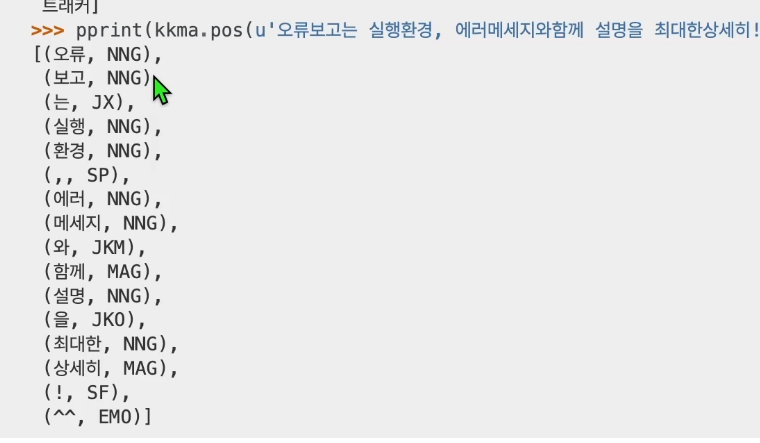

In [22]:
from langchain_teddynote.community.pinecone import (
    create_sparse_encoder,
    fit_sparse_encoder,
)

# 한글 불용어 사전 + Kiwi 형태소 분석기를 사용합니다.
sparse_encoder = create_sparse_encoder(stopwords(), mode="kiwi")

[nltk_data] Downloading package punkt to /Users/matagi/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matagi/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Sparse Encoder 에 Corpus 를 학습합니다.

- `save_path`: Sparse Encoder 를 저장할 경로입니다. 추후에 `pickle` 형식으로 저장한 Sparse Encoder 를 불러와 Query 임베딩할 때 사용합니다. 따라서, 이를 저장할 경로를 지정합니다.

In [23]:
len(contents)

2324

In [24]:
# Sparse Encoder 를 사용하여 contents 를 학습
saved_path = fit_sparse_encoder(
    sparse_encoder=sparse_encoder, contents=contents, save_path="./sparse_encoder.pkl"
)

  0%|          | 0/2324 [00:00<?, ?it/s]

[fit_sparse_encoder]
Saved Sparse Encoder to: ./sparse_encoder.pkl


[선택사항] 아래는 나중에 학습하고 저장한 Sparse Encoder 를 다시 불러와야 할 때 사용하는 코드입니다.    

In [25]:
from langchain_teddynote.community.pinecone import load_sparse_encoder

# 추후에 학습된 sparse encoder 를 불러올 때 사용합니다.
sparse_encoder = load_sparse_encoder("./sparse_encoder.pkl")

[load_sparse_encoder]
Loaded Sparse Encoder from: ./sparse_encoder.pkl


### Pinecone: DB Index에 추가 (Upsert)

- Upsert -> Update + Insert

![](./images/pinecone-02.png)

- `context`: 문서의 내용입니다.
- `page`: 문서의 페이지 번호입니다.
- `source`: 문서의 출처입니다.
- `values`: Embedder 를 통해 얻은 문서의 임베딩입니다.
- `sparse values`: Sparse Encoder 를 통해 얻은 문서의 임베딩입니다.

In [26]:
from langchain_openai import OpenAIEmbeddings
from langchain_upstage import UpstageEmbeddings

# 임베딩 모델 생성
openai_embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
upstage_embeddings = UpstageEmbeddings(model="solar-embedding-1-large-passage")

분산 처리를 하지 않고 배치 단위로 문서를 Upsert 합니다. 문서의 양이 많지 않다면 아래의 방식을 사용하세요.

In [27]:
%%time
from langchain_teddynote.community.pinecone import upsert_documents
from langchain_upstage import UpstageEmbeddings

upsert_documents(
    index=pc_index,  # Pinecone 인덱스
    namespace="teddynote-namespace-01",  # Pinecone namespace (폴더의 개념)
    contents=contents,  # 이전에 전처리한 문서 내용
    metadatas=metadatas,  # 이전에 전처리한 문서 메타데이터
    sparse_encoder=sparse_encoder,  # Sparse encoder
    embedder=upstage_embeddings, # 의미 검색할 때 사용할 것
    batch_size=32,
)

  0%|          | 0/73 [00:00<?, ?it/s]

KeyboardInterrupt: 

아래는 분산처리를 수행하여 대용량 문서를 빠르게 Upsert 합니다. 대용량 업로드시 활용하세요.

In [28]:
%%time
from langchain_teddynote.community.pinecone import upsert_documents_parallel

upsert_documents_parallel(
    index=pc_index,  # Pinecone 인덱스
    namespace="teddynote-namespace-02",  # Pinecone namespace
    contents=contents,  # 이전에 전처리한 문서 내용
    metadatas=metadatas,  # 이전에 전처리한 문서 메타데이터
    sparse_encoder=sparse_encoder,  # Sparse encoder
    embedder=upstage_embeddings,
    batch_size=64,
    max_workers=30,
)

문서 Upsert 중:   0%|          | 0/37 [00:00<?, ?it/s]

총 2324개의 Vector 가 Upsert 되었습니다.
{'dimension': 4096,
 'index_fullness': 0.0,
 'namespaces': {'teddynote-namespace-01': {'vector_count': 864},
                'teddynote-namespace-02': {'vector_count': 2196}},
 'total_vector_count': 3060}
CPU times: user 36.1 s, sys: 1.05 s, total: 37.2 s
Wall time: 41.9 s


## 인덱스 조회/삭제

`describe_index_stats` 메서드는 인덱스의 내용에 대한 통계 정보를 제공합니다. 이 메서드를 통해 네임스페이스별 벡터 수와 차원 수 등의 정보를 얻을 수 있습니다.

**매개변수**
* `filter` (Optional[Dict[str, Union[str, float, int, bool, List, dict]]]): 특정 조건에 맞는 벡터들에 대한 통계만 반환하도록 하는 필터. 기본값은 None
* `**kwargs`: 추가 키워드 인자

**반환값**
* `DescribeIndexStatsResponse`: 인덱스에 대한 통계 정보를 담고 있는 객체

**사용 예시**
* 기본 사용: `index.describe_index_stats()`
* 필터 적용: `index.describe_index_stats(filter={'key': 'value'})`

**참고**
- metadata 필터링은 유료 사용자에 한하여 가능합니다.

In [31]:
# 인덱스 조회
pc_index.describe_index_stats()

{'dimension': 4096,
 'index_fullness': 0.0,
 'namespaces': {'teddynote-namespace-02': {'vector_count': 2324}},
 'total_vector_count': 2324}

### 네임스페이스(namespace) 삭제

In [30]:
from langchain_teddynote.community.pinecone import delete_namespace

delete_namespace(
    pinecone_index=pc_index,
    namespace="teddynote-namespace-01",
)

네임스페이스 'teddynote-namespace-01'의 모든 데이터가 삭제되었습니다.


In [32]:
pc_index.describe_index_stats()

{'dimension': 4096,
 'index_fullness': 0.0,
 'namespaces': {'teddynote-namespace-02': {'vector_count': 2324}},
 'total_vector_count': 2324}

아래는 유료 사용자 전용 기능입니다. 유료 사용자는 metadata 필터링을 사용할 수 있습니다.

In [ ]:
from langchain_teddynote.community.pinecone import delete_by_filter

# metadata 필터링(유료 기능) 으로 삭제
delete_by_filter(
    pinecone_index=pc_index,
    namespace="teddynote-namespace-02",
    filter={"source": {"$eq": "SPRi AI Brief_8월호_산업동향.pdf"}},
)
pc_index.describe_index_stats()

## 검색기(Retriever) 생성

### PineconeKiwiHybridRetriever 초기화 파라미터 설정

`init_pinecone_index` 함수와 `PineconeKiwiHybridRetriever` 클래스는 Pinecone을 사용한 하이브리드 검색 시스템을 구현합니다. 

이 시스템은 밀집 벡터와 희소 벡터를 결합하여 효과적인 문서 검색을 수행합니다.

**Pinecone 인덱스 초기화**

`init_pinecone_index` 함수는 Pinecone 인덱스를 초기화하고 필요한 구성 요소를 설정합니다.

**매개변수**
* `index_name` (str): Pinecone 인덱스 이름
* `namespace` (str): 사용할 네임스페이스
* `api_key` (str): Pinecone API 키
* `sparse_encoder_pkl_path` (str): 희소 인코더 피클 파일 경로
* `stopwords` (List[str]): 불용어 리스트
* `tokenizer` (str): 사용할 토크나이저 (기본값: "kiwi")
* `embeddings` (Embeddings): 임베딩 모델
* `top_k` (int): 반환할 최대 문서 수 (기본값: 10)
* `alpha` (float): 밀집 벡터와 희소 벡터의 가중치 조절 파라미터 (기본값: 0.5)

**주요 기능**
1. Pinecone 인덱스 초기화 및 통계 정보 출력
2. 희소 인코더(BM25) 로딩 및 토크나이저 설정
3. 네임스페이스 지정

In [1]:
# !pip install -U pinecone langchain-teddynote

In [ ]:
import os
from langchain_teddynote.korean import stopwords
from langchain_teddynote.community.pinecone import init_pinecone_index
from langchain_upstage import UpstageEmbeddings

pinecone_params = init_pinecone_index(
    index_name="teddynote-db-index",  # Pinecone 인덱스 이름
    namespace="teddynote-namespace-02",  # Pinecone Namespace
    api_key=os.environ["PINECONE_API_KEY"],  # Pinecone API Key
    sparse_encoder_path="./sparse_encoder.pkl",  # Sparse Encoder 저장경로(save_path)
    stopwords=stopwords(),  # 불용어 사전
    tokenizer="kiwi",
    embeddings=UpstageEmbeddings(
        model="solar-embedding-1-large-query"
    ),  # Dense Embedder
    top_k=5,  # Top-K 문서 반환 개수
    alpha=0.5,  # alpha=0.75로 설정한 경우, (0.75: Dense Embedding, 0.25: Sparse Embedding)
    # 하이브리드 서치의 장점 (키워드 검색: 0에 가깝게, 의미 검색: 1에 가깝게)
)

[init_pinecone_index]
{'dimension': 4096,
 'index_fullness': 0.0,
 'namespaces': {'teddynote-namespace-02': {'vector_count': 2324}},
 'total_vector_count': 2324}


### PineconeKiwiHybridRetriever

`PineconeKiwiHybridRetriever` 클래스는 Pinecone과 Kiwi를 결합한 하이브리드 검색기를 구현합니다.

**주요 속성**
* `embeddings`: 밀집 벡터 변환용 임베딩 모델
* `sparse_encoder`: 희소 벡터 변환용 인코더
* `index`: Pinecone 인덱스 객체
* `top_k`: 반환할 최대 문서 수
* `alpha`: 밀집 벡터와 희소 벡터의 가중치 조절 파라미터
* `namespace`: Pinecone 인덱스 내 네임스페이스

**특징**
* 밀집 벡터와 희소 벡터를 결합한 HybridSearch Retriever
* 가중치 조절을 통한 검색 전략 최적화 가능
* 다양한 동적 metadata 필터링 적용 가능(`search_kwargs` 사용: `filter`, `k`, `rerank`, `rerank_model`, `top_n` 등)

**사용 예시**
1. `init_pinecone_index` 함수로 필요한 구성 요소 초기화
2. 초기화된 구성 요소로 `PineconeKiwiHybridRetriever` 인스턴스 생성
3. 생성된 검색기를 사용하여 하이브리드 검색 수행

`PineconeKiwiHybridRetriever` 를 생성합니다.

In [34]:
from langchain_teddynote.community.pinecone import PineconeKiwiHybridRetriever

# 검색기 생성
pinecone_retriever = PineconeKiwiHybridRetriever(**pinecone_params)

일반 검색

In [35]:
# 실행 결과
search_results = pinecone_retriever.invoke("gpt-4o 미니 출시 관련 정보에 대해서 알려줘")
for result in search_results:
    print(result.page_content)
    print(result.metadata)
    print("\n====================\n")

앤트로픽의 클로드 하이쿠보다 높은 점수를 기록
KEY Contents
£ GPT-4o 미니, GPT-3.5 터보 대비 60% 이상 저렴하면서 성능은 우수
n 오픈AI는 2024년 7월 28일 가장 비용 효율적인 소형 모델인 ‘GPT-4o 미니’를 출시하고 챗GPT에서 
GPT-3.5를 대신해 무료 사용자 및 플러스와 팀 사용자에게 제공한다고 발표
∙GPT-4o 미니는 입력 토큰 100만 개당 15센트, 출력 토큰 100만 개당 60센트로 가격이 책정되어, 
GPT-3.5 터보 대비 60% 이상 저렴
{'author': 'dj', 'context': '앤트로픽의 클로드 하이쿠보다 높은 점수를 기록\nKEY Contents\n£ GPT-4o 미니, GPT-3.5 터보 대비 60% 이상 저렴하면서 성능은 우수\nn 오픈AI는 2024년 7월 28일 가장 비용 효율적인 소형 모델인 ‘GPT-4o 미니’를 출시하고 챗GPT에서 \nGPT-3.5를 대신해 무료 사용자 및 플러스와 팀 사용자에게 제공한다고 발표\n∙GPT-4o 미니는 입력 토큰 100만 개당 15센트, 출력 토큰 100만 개당 60센트로 가격이 책정되어, \nGPT-3.5 터보 대비 60% 이상 저렴', 'page': 13.0, 'source': 'SPRi AI Brief_8월호_산업동향.pdf'}


1. 정책/법제  
2. 기업/산업 
3. 기술/연구 
 4. 인력/교육
11
오픈AI, 비용 효율적인 소형 AI 모델 ‘GPT-4o 미니’ 출시
n 오픈AI가 GPT-3.5 터보 대비 60% 이상 저렴한 소형 모델 ‘GPT-4o’ 미니를 발표했으며, 저렴한 
비용과 낮은 지연 시간으로 다양한 애플리케이션에 활용될 것으로 기대
n GPT-4o는 주요 벤치마크에서 GPT-3.5를 앞섰으며, 경쟁 소형 모델인 구글의 제미나이 플래시와 
앤트로픽의 클로드 하이쿠보다 높은 점수를 기록
KEY Contents
{'author': 'dj', 'context': '1. 정책/법제  \n2. 기업/산업

동적 `search_kwargs` 사용
- `k`: 반환할 최대 문서 수 지정

In [36]:
# 실행 결과
search_results = pinecone_retriever.invoke(
    "gpt-4o 미니 출시 관련 정보에 대해서 알려줘", search_kwargs={"k": 1}
)
for result in search_results:
    print(result.page_content)
    print(result.metadata)
    print("\n====================\n")

앤트로픽의 클로드 하이쿠보다 높은 점수를 기록
KEY Contents
£ GPT-4o 미니, GPT-3.5 터보 대비 60% 이상 저렴하면서 성능은 우수
n 오픈AI는 2024년 7월 28일 가장 비용 효율적인 소형 모델인 ‘GPT-4o 미니’를 출시하고 챗GPT에서 
GPT-3.5를 대신해 무료 사용자 및 플러스와 팀 사용자에게 제공한다고 발표
∙GPT-4o 미니는 입력 토큰 100만 개당 15센트, 출력 토큰 100만 개당 60센트로 가격이 책정되어, 
GPT-3.5 터보 대비 60% 이상 저렴
{'author': 'dj', 'context': '앤트로픽의 클로드 하이쿠보다 높은 점수를 기록\nKEY Contents\n£ GPT-4o 미니, GPT-3.5 터보 대비 60% 이상 저렴하면서 성능은 우수\nn 오픈AI는 2024년 7월 28일 가장 비용 효율적인 소형 모델인 ‘GPT-4o 미니’를 출시하고 챗GPT에서 \nGPT-3.5를 대신해 무료 사용자 및 플러스와 팀 사용자에게 제공한다고 발표\n∙GPT-4o 미니는 입력 토큰 100만 개당 15센트, 출력 토큰 100만 개당 60센트로 가격이 책정되어, \nGPT-3.5 터보 대비 60% 이상 저렴', 'page': 13.0, 'source': 'SPRi AI Brief_8월호_산업동향.pdf'}




동적 `search_kwargs` 사용
- `alpha`: 밀집 벡터와 희소 벡터의 가중치 조절 파라미터. 0과 1 사이의 값을 지정합니다. `0.5` 가 기본값이고, 1에 가까울수록 dense 벡터의 가중치가 높아집니다.

In [37]:
# 실행 결과
search_results = pinecone_retriever.invoke(
    "앤스로픽", search_kwargs={"alpha": 1, "k": 1}
)
for result in search_results:
    print(result.page_content)
    print(result.metadata)
    print("\n====================\n")

n 앤스로픽은 개발자 콘솔도 업데이트하여, 개발자가 여러 프롬프트를 생성하고 테스트함으로써 
클로드를 최적화할 수 있도록 지원
∙앤스로픽은 사용자가 클로드에 맞춤형 지침을 제공할 수 있는 ‘시스템 프롬프트’ 기능도 도입할 
예정으로, 이 기능은 클로드가 사용자 요구에 맞춤화된 방식으로 체계적 응답을 할 수 있도록 지원
☞ 출처 : Anthropic, Introducing Claude 2.1, 2023.11.21.
{'author': 'dj', 'context': 'n 앤스로픽은 개발자 콘솔도 업데이트하여, 개발자가 여러 프롬프트를 생성하고 테스트함으로써 \n클로드를 최적화할 수 있도록 지원\n∙앤스로픽은 사용자가 클로드에 맞춤형 지침을 제공할 수 있는 ‘시스템 프롬프트’ 기능도 도입할 \n예정으로, 이 기능은 클로드가 사용자 요구에 맞춤화된 방식으로 체계적 응답을 할 수 있도록 지원\n☞ 출처 : Anthropic, Introducing Claude 2.1, 2023.11.21.', 'page': 7.0, 'source': 'SPRi AI Brief_2024년1월호_F.pdf'}




## 검색 결과가 달라짐 == 검색의 품질에 영향

In [38]:
# 실행 결과
search_results = pinecone_retriever.invoke(
    "앤스로픽", search_kwargs={"alpha": 0, "k": 1}
)
for result in search_results:
    print(result.page_content)
    print(result.metadata)
    print("\n====================\n")

1. 정책/법제  
2. 기업/산업 
3. 기술/연구 
 4. 인력/교육
구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 
n 구글이 앤스로픽에 최대 20억 달러 투자에 합의하고 5억 달러를 우선 투자했으며, 앤스로픽은 
구글과 클라우드 서비스 사용 계약도 체결
n 3대 클라우드 사업자인 구글, 마이크로소프트, 아마존은 차세대 AI 모델의 대표 기업인 
앤스로픽 및 오픈AI와 협력을 확대하는 추세
KEY Contents
£ 구글, 앤스로픽에 최대 20억 달러 투자 합의 및 클라우드 서비스 제공
{'author': 'dj', 'context': '1. 정책/법제  \n2. 기업/산업 \n3. 기술/연구 \n 4. 인력/교육\n구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 \nn 구글이 앤스로픽에 최대 20억 달러 투자에 합의하고 5억 달러를 우선 투자했으며, 앤스로픽은 \n구글과 클라우드 서비스 사용 계약도 체결\nn 3대 클라우드 사업자인 구글, 마이크로소프트, 아마존은 차세대 AI 모델의 대표 기업인 \n앤스로픽 및 오픈AI와 협력을 확대하는 추세\nKEY Contents\n£ 구글, 앤스로픽에 최대 20억 달러 투자 합의 및 클라우드 서비스 제공', 'page': 13.0, 'source': 'SPRI_AI_Brief_2023년12월호_F (4).pdf'}




**Metadata 필터링**

![](./images/pinecone-metadata.png)

동적 `search_kwargs` 사용
- `filter`: metadata 필터링 적용

(예시) `page` 가 5보다 작은 문서만 검색합니다.

In [39]:
# 실행 결과
search_results = pinecone_retriever.invoke(
    "앤스로픽의 claude 출시 관련 내용을 알려줘",
    search_kwargs={"filter": {"page": {"$lt": 5}}, "k": 2},
)
for result in search_results:
    print(result.page_content)
    print(result.metadata)
    print("\n====================\n")

▹ 앤스로픽, 최신 AI 모델 ‘클로드 3.5 소네트’ 출시··························································· 10
   ▹ 프랑스의 미스트랄AI, 6억 유로 규모의 투자 유치  ························································ 11
{'author': 'dj', 'context': '▹ 앤스로픽, 최신 AI 모델 ‘클로드 3.5 소네트’ 출시··························································· 10\n   ▹ 프랑스의 미스트랄AI, 6억 유로 규모의 투자 유치  ························································ 11', 'page': 1.0, 'source': 'SPRi AI Brief_7월호_산업동향.pdf'}


▹ 코히어, 기업용 AI 챗봇 ‘코랄(Coral)’ 출시 ······································································· 7
   ▹ 알리바바 클라우드, 대규모 언어모델 2종을 오픈소스로 공개 ··········································· 8
   ▹ SK텔레콤, 미국 생성 AI 기업 앤스로픽에 1억 달러 투자·················································· 9
{'author': 'dj', 'context': '▹ 코히어, 기업용 AI 챗봇 ‘코랄(Coral)’ 출시 ······································································· 7\n   ▹ 알리바바 클라우드, 대규모 언어모델 2종을 오픈소스로 공개 ··········································· 8\n   ▹ SK텔레콤, 미국 생성 

동적 `search_kwargs` 사용
- `filter`: metadata 필터링 적용

(예시) `source` 가 `SPRi AI Brief_8월호_산업동향.pdf` 문서내 검색합니다.

In [44]:
# 실행 결과
search_results = pinecone_retriever.invoke(
    "앤트로픽",
    search_kwargs={
        "filter": {"source": {"$eq": "SPRI_AI_Brief_2023년8월호_스페셜.pdf"}},
        "k": 3,
    },
)
for result in search_results:
    print(result.page_content)
    print(result.metadata)
    print("\n====================\n")

## Reranking 적용

- 동적 reranking 기능을 구현해 놓았지만, pinecone 라이브러리 의존성에 문제가 있을 수 있습니다.
- 따라서, 아래 코드는 향후 의존성 해결 후 원활하게 동작할 수 있습니다.

참고 문서: https://docs.pinecone.io/guides/inference/rerank

### 검색의 품질을 향상 시킬 수 있는 방법 중 하나.

In [45]:
# reranker 미사용
retrieval_results = pinecone_retriever.invoke(
    "앤스로픽의 클로드 소넷",
)

# BGE-reranker-v2-m3 모델 사용
reranked_results = pinecone_retriever.invoke(
    "앤스로픽의 클로드 소넷",
    search_kwargs={"rerank": True, "rerank_model": "bge-reranker-v2-m3", "top_n": 3},
)

In [46]:
# retrieval_results 와 reranked_results 를 비교합니다.
for res1, res2 in zip(retrieval_results, reranked_results):
    print("[Retrieval]")
    print(res1.page_content)
    print("\n------------------\n")
    print("[Reranked] rerank_score: ", res2.metadata["rerank_score"])
    print(res2.page_content)
    print("\n====================\n")

[Retrieval]
1. 정책/법제  
2. 기업/산업 
3. 기술/연구 
 4. 인력/교육
9
앤스로픽, 최신 AI 모델 ‘클로드 3.5 소네트’ 출시 
n 앤스로픽이 최신 AI 모델 ‘클로드 3.5 소네트’을 공개하고 이전 모델 중 가장 고성능 모델인 
‘클로드 3 오퍼스’나 오픈AI의 최신 모델 ‘GPT-4o’보다 성능이 뛰어나다고 강조
n 앤스로픽은 클로드로 생성한 코딩이나 문서 등을 실시간으로 확인해 편집과 같은 작업을 할 수 
있는 ‘아티팩트’ 신기능도 출시
KEY Contents

------------------

[Reranked] rerank_score:  0.99635005
1. 정책/법제  
2. 기업/산업 
3. 기술/연구 
 4. 인력/교육
9
앤스로픽, 최신 AI 모델 ‘클로드 3.5 소네트’ 출시 
n 앤스로픽이 최신 AI 모델 ‘클로드 3.5 소네트’을 공개하고 이전 모델 중 가장 고성능 모델인 
‘클로드 3 오퍼스’나 오픈AI의 최신 모델 ‘GPT-4o’보다 성능이 뛰어나다고 강조
n 앤스로픽은 클로드로 생성한 코딩이나 문서 등을 실시간으로 확인해 편집과 같은 작업을 할 수 
있는 ‘아티팩트’ 신기능도 출시
KEY Contents


[Retrieval]
▹ 앤스로픽, 최신 AI 모델 ‘클로드 3.5 소네트’ 출시··························································· 10
   ▹ 프랑스의 미스트랄AI, 6억 유로 규모의 투자 유치  ························································ 11

------------------

[Reranked] rerank_score:  0.9956346
있는 ‘아티팩트’ 신기능도 출시
KEY Contents
£ 클로드 3.5 소네트, 이전 대표모델 클로드 3 오퍼스와 오픈AI의 GPT-4o 능가
n 앤스로픽이 2024년 6월 21일 ‘클로드(Claude) 3.5’ 모델군 중 첫 번째로 ‘소